# 机器学习纳米学位

> ## 毕业项目——算式识别（Mathematical Expression Recognition）
<div style="text-align: right">王新平 2019 年 6 月 16 日</div>

## 数据准备

In [1]:
#!wget "https://s3.cn-north-1.amazonaws.com.cn/static-documents/nd009/MLND+Capstone/Mathematical_Expression_Recognition_train.zip"
#!unzip -q -d data Mathematical_Expression_Recognition_train.zip
#!rm Mathematical_Expression_Recognition_train.zip
data_dir = 'data'

## 加载数据

In [2]:
import os
import pandas as pd

In [3]:
data_frame = pd.read_csv(os.path.join(data_dir, 'train.csv'))
data_frame.head()

,filename,label
0,train/0.jpg,(0+0)+9=9
1,train/1.jpg,9*8+6=78
2,train/2.jpg,1+7+0=8
3,train/3.jpg,5+4+9=18
4,train/4.jpg,7-(1*7)=0


### 可视化部分数据

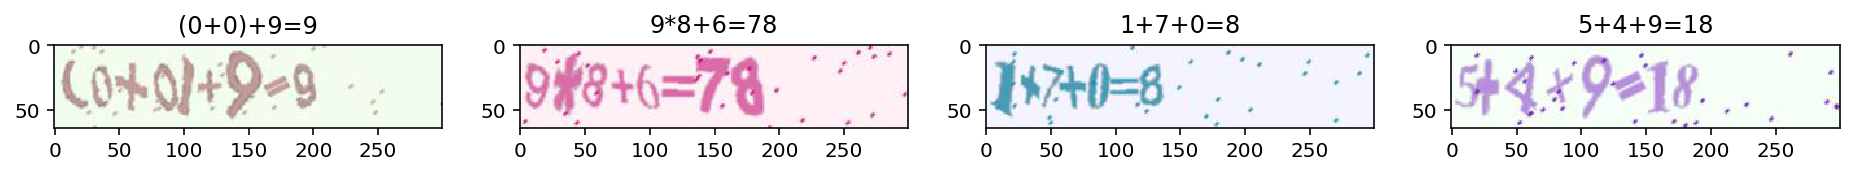

In [4]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def imshow(imgs, labels, cols=4):
    # calculate row to show images
    rows = len(imgs) // cols + 1
    
    # create a new figure
    fig = plt.figure(figsize=(16, 5))
    
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(labels[i])

examples = data_frame.iloc[0:4]
example_imgs = list((plt.imread(os.path.join(data_dir, x)) for x in examples['filename']))
example_labels = examples['label'].array

imshow(example_imgs, example_labels)
    

Text(0, 0.5, 'count')

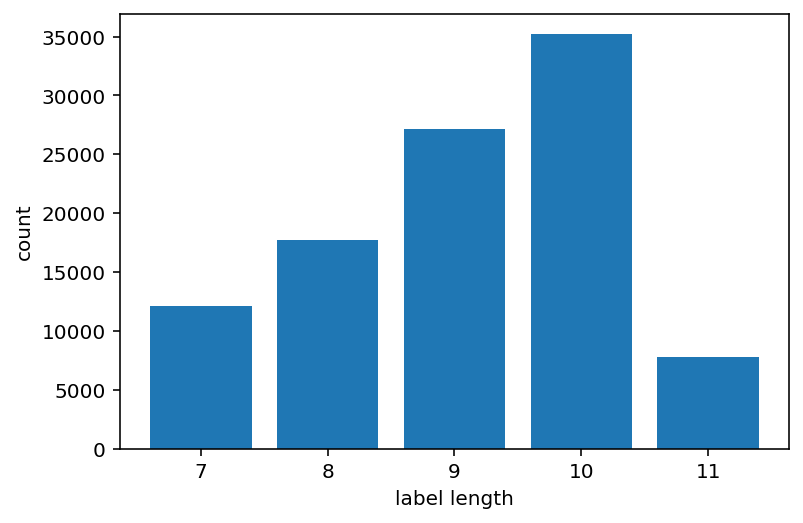

In [5]:
from collections import defaultdict

label_len_count = defaultdict(int)

for label in data_frame['label']:
    label_len_count[len(label)] += 1

plt.bar(label_len_count.keys(), label_len_count.values())
plt.xlabel('label length')
plt.ylabel('count')

Text(0, 0.5, 'count')

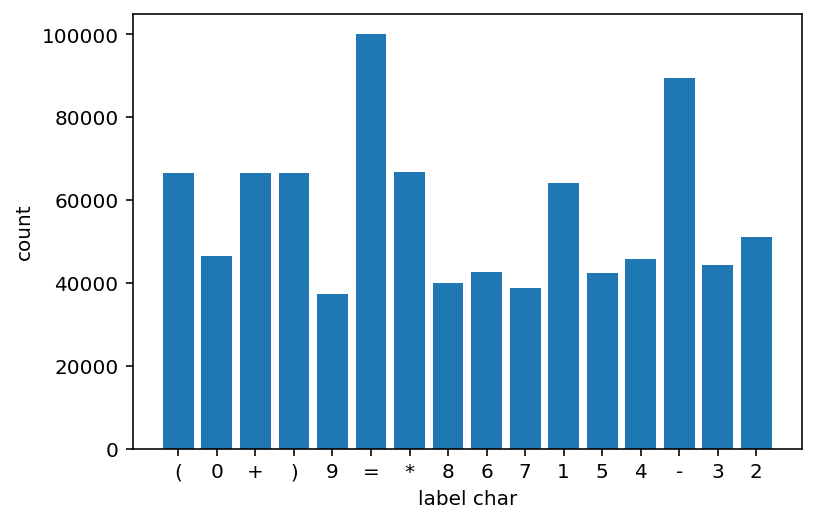

In [6]:
label_char_count = defaultdict(int)

for label in data_frame['label']:
    for c in label:
        label_char_count[c] += 1

plt.bar(label_char_count.keys(), label_char_count.values())
plt.xlabel('label char')
plt.ylabel('count')

## 定义数据集

将数据集划分为训练集、验证集和测试集。

In [7]:
from torch.utils.data.dataset import Dataset

class MathExpDataset(Dataset):
    
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[index, 0])
        
        image = plt.imread(img_name)
        label = self.data_frame.iloc[index, 1]
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

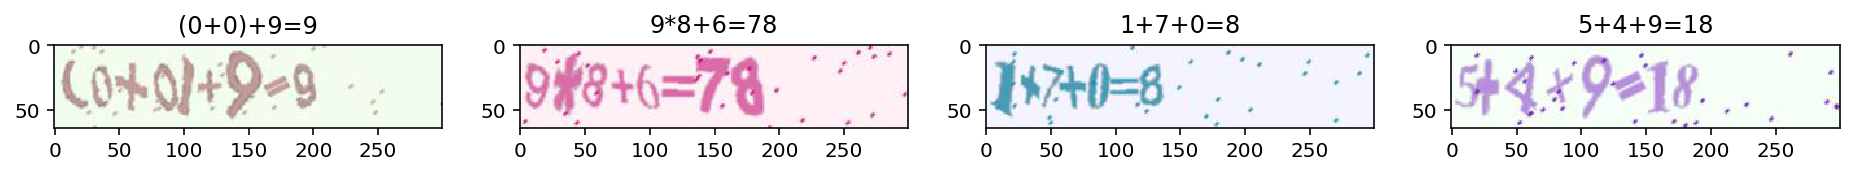

In [8]:
math_exp_dataset = MathExpDataset(data_frame=data_frame, root_dir=data_dir)

samples = []
for i in range(len(math_exp_dataset)):
    samples.append(math_exp_dataset[i])
    
    if i == 3:
        break

imshow(list(x['image'] for x in samples), list(x['label'] for x in samples))

In [9]:
import torch
from torchvision.transforms import transforms

class ToGray(object):
    def __init__(self):
        self.transform = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale()])
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = self.transform(image)
        return {'image': image, 'label': label}
    
class ToTensor(object):
    """Convert PIL Image in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # the image after ToGray is two dims
        image = np.expand_dims(image, axis=0)
        
        return {'image': torch.from_numpy(image), 'label': label}

class Normalize(object):
    def __init__(self, mean=[127.5], std=[127.5]):
        self.normalize = transforms.Normalize(mean=mean, std=std)
    
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        return {'image': self.normalize(image.float()), 'label': label}

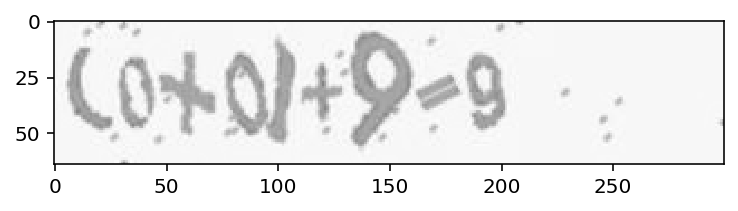

In [10]:
import matplotlib.cm as cm

to_gray = ToGray()
plt.imshow(to_gray(math_exp_dataset[0])['image'], cmap=cm.gray, vmin=0, vmax=255)

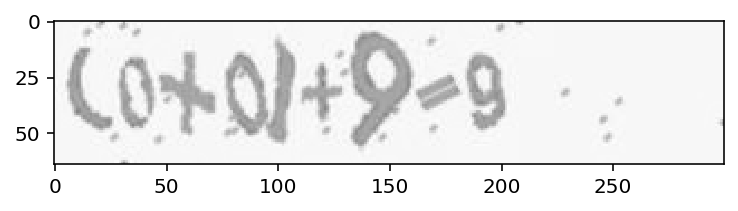

In [11]:
transform_compose = transforms.Compose([ToGray(), ToTensor(), Normalize()])
transformed_sample = transform_compose(math_exp_dataset[0])

plt.imshow(transformed_sample['image'].numpy()[0], cmap=cm.gray, vmin=-1, vmax=1)

In [12]:
print(transformed_sample['image'].shape)
print(transformed_sample['label'])

torch.Size([1, 64, 300])
(0+0)+9=9


In [13]:
math_exp_dataset = MathExpDataset(data_frame=data_frame, root_dir=data_dir,
                                  transform=transforms.Compose([ToGray(), ToTensor(), Normalize()]))

## 划分数据集

In [14]:
from torch.utils.data import dataset

split_lens = (len(math_exp_dataset) // 10 * 8, len(math_exp_dataset) // 10, len(math_exp_dataset) // 10)

splited_temp = dataset.random_split(math_exp_dataset, split_lens)

math_exp_dataset_splited = {x: splited_temp[i] 
                            for i, x in enumerate(['train', 'val', 'test'])}

In [15]:
batch_size = 64
data_loaders = {x: torch.utils.data.DataLoader(math_exp_dataset_splited[x], batch_size,
                                              shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}

## 模型定义

In [16]:
import torch.nn as nn
from collections import OrderedDict

class BidirectionalLSTM(nn.Module):
    
    def __init__(self, input_size, num_layers, num_classes):
        super(BidirectionalLSTM, self).__init__()
        
        # 默认 hidden_size 和 input_size 一致
        self.rnn = nn.LSTM(input_size, input_size, num_layers, bidirectional=True)
        self.embedding = nn.Linear(input_size * 2, num_classes)
    
    def forward(self, input):
        # input of shape (seq_len, batch, input_size): tensor containing the features of the input sequence. 
        # The input can also be a packed variable length sequence.
        #
        # output of shape (seq_len, batch, num_directions * hidden_size)
        # If the LSTM is bidirectional, num_directions should be 2, else it should be 1.
        output, _ = self.rnn(input)
        
        return output


class TransNet(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(TransNet, self).__init__()
        
        self.embedding = nn.Linear(input_size, num_classes)
        self.log_softmax = nn.LogSoftmax(dim = 2)
    
    def forward(self, input):
        # seq_len, batch, feature_size = input.size()
        output = self.embedding(input)
        output = self.log_softmax(output)
        return output

class ConvRecNet(nn.Module):
    
    def __init__(self, class_size):
        super(ConvRecNet, self).__init__()
        
        self.cnn = nn.Sequential(OrderedDict([
            # batch x channels x height x width: (-1 x 1 x 64 x 300) -> (-1 x 8 x 64 x 300)
            ('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)),
            # active
            ('relu1', nn.ReLU()),
            # (-1 x 8 x 64 x 300) -> (-1 x 8 x 32 x 150)
            ('pool1', nn.MaxPool2d(2)),
            
            # batch x channels x height x width: (-1 x 8 x 32 x 150) -> (-1 x 16 x 32 x 150)
            ('conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)),
            # active
            ('relu2', nn.ReLU()),
            # (-1 x 16 x 32 x 150) -> (-1 x 16 x 16 x 75)
            ('pool2', nn.MaxPool2d(2)),
            
            # batch x channels x height x width: (-1 x 16 x 16 x 75) -> (-1 x 32, 16, 75)
            ('conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)),
            # active
            ('relu3', nn.ReLU()),
            # (-1 x 32 x 16 x 75) -> (-1 x 32 x 8 x 38)
            ('pool3', nn.MaxPool2d(2, padding=(0, 1))),
            
            # batch x channels x height x width: (-1 x 32 x 8 x 38) -> (-1 x 64 x 8 x 38)
            ('conv4', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
            # active
            ('relu4', nn.ReLU()),
            # (-1 x 64 x 8 x 38) -> (-1 x 64 x 4 x 19)
            ('pool4', nn.MaxPool2d(2)),
            
            # batch x channels x height x width: (-1 x 64 x 4 x 19) -> (-1 x 128 x 4 x 19)
            ('conv5', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)),
            # active
            ('relu5', nn.ReLU()),
            # (-1 x 128 x 4 x 19) -> (-1 x 128 x 2 x 19)
            ('pool5', nn.MaxPool2d((2, 1))),
            
            # batch x channels x height x width: (-1 x 128 x 2 x 19) -> (-1 x 256 x 2 x 19)
            ('conv6', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)),
            # active
            ('relu6', nn.ReLU()),
            # (-1 x 256 x 2 x 10) -> (-1 x 256 x 1 x 19)
            ('pool6', nn.MaxPool2d((2, 1))),
            
            # linear: (-1 x 256 x 1 x 19) -> (-1 x 256 x 1 x 16)
            ('linear', nn.Linear(19, 16)),
            # active
            ('relu6', nn.ReLU())
        ]))
        
        self.rnn = BidirectionalLSTM(256, 2, class_size)
        
        self.trans = TransNet(512, class_size)
        
    def forward(self, input):
        conv = self.cnn(input)
        b, c, h, w = conv.size() # (-1 x 256 x 1 x 19)
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2) # b, c, w (-1 x 256 x 19)
        conv = conv.permute(2, 0, 1) # w, b, c (19, -1 x 256)
        
        output = self.rnn(conv)
        
        output = self.trans(output)
        
        return output

In [17]:
chars = '1234567890+-*=()'

net = ConvRecNet(len(chars))
print(net)

ConvRecNet(
  (cnn): Sequential(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu4): ReLU()
    (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU()
    (pool5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv6): Conv2d

In [18]:
def indexes_to_label(indexes):
    return ''.join([chars[i] for i in indexes])

def label_to_indexes(label):
    return [chars.index(c) for c in label]

loss_fun = nn.CTCLoss()

def criterion(predicts, labels):
    input_lengths = torch.full(size=(predicts.shape[1],), fill_value=predicts.shape[2], dtype=torch.int64)
    target_lenths = torch.tensor([len(l) for l in labels])
    max_len = max(target_lenths).numpy()
    targets = []
    for label in labels:
        label_indexes = label_to_indexes(label)
        label_indexes.extend([0] * (max_len - len(label)))
        targets.append(label_indexes)
    targets = torch.tensor(targets)
    
    loss = loss_fun(predicts, targets, input_lengths, target_lenths)
    
    return loss

for i, data in enumerate(data_loaders['train']):
    if i == 1:
        break
    images, labels = data['image'], data['label']
    predicts = net.forward(images)
    loss = criterion(predicts, labels)
    print('loss: {}'.format(loss))
    predicts = predicts.permute((1, 0, 2))
    predicts_indexes = np.argmax(predicts.detach().numpy(), axis=2)
    for i, (predict_indexes, label) in enumerate(zip(predicts_indexes, labels)):
        predict = indexes_to_label(predict_indexes)
        print('label: {}'.format(label))
        print('predict: {}'.format(predict))
        if i == 3:
            break

loss: 3.5511677265167236
label: (1-5)+4=0
predict: 4444444444444344
label: 5*5+5=30
predict: 4444444444444344
label: 6*(8*7)=336
predict: 4444444444444344
label: 4+7*6=46
predict: 4444444444444344


In [ ]:
import torch.optim as optim

learning_rate = 0.001

optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_loaders['train']):
        
        images, labels = data['image'], data['label']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicts = net.forward(images)
        loss = criterion(predicts, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

## 参考连接
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html

https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html